In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data_path = 'Pneumonia_Dataset/train'
filepaths = []
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path, fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
df = pd.concat([Fseries, Lseries], axis=1) 

In [3]:
df

filepaths      label
0      Pneumonia_Dataset/train\NORMAL\IM-0115-0001.jpeg     NORMAL
1      Pneumonia_Dataset/train\NORMAL\IM-0117-0001.jpeg     NORMAL
2      Pneumonia_Dataset/train\NORMAL\IM-0119-0001.jpeg     NORMAL
3      Pneumonia_Dataset/train\NORMAL\IM-0122-0001.jpeg     NORMAL
4      Pneumonia_Dataset/train\NORMAL\IM-0125-0001.jpeg     NORMAL
...                                                 ...        ...
5211  Pneumonia_Dataset/train\PNEUMONIA\person99_vir...  PNEUMONIA
5212  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA
5213  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA
5214  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA
5215  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA

[5216 rows x 2 columns]

In [4]:
test_data_path = 'Pneumonia_Dataset/test'

filepaths = []
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path, fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
test = pd.concat([Fseries, Lseries], axis=1)

In [5]:
valid_data_path = 'Pneumonia_Dataset/val'

filepaths = []
labels = []
folds = os.listdir(valid_data_path)

for fold in folds:
    f_path = os.path.join(valid_data_path, fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
valid = pd.concat([Fseries, Lseries], axis=1)

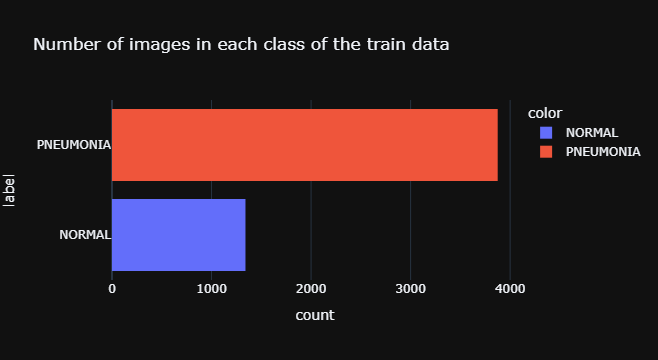

In [6]:
fig = px.histogram(data_frame=df,
                   y=df['label'],
                   template='plotly_dark',
                   color=df['label'].values,
                   title='Number of images in each class of the train data')
fig.show()

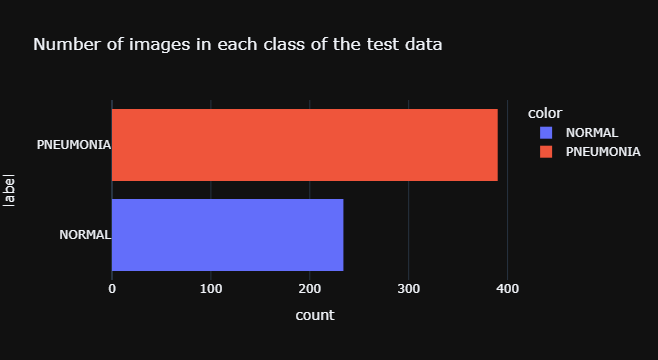

In [7]:
fig = px.histogram(data_frame=test,
                   y=test['label'],
                   template='plotly_dark',
                   color=test['label'].values,
                   title='Number of images in each class of the test data')
fig.show()

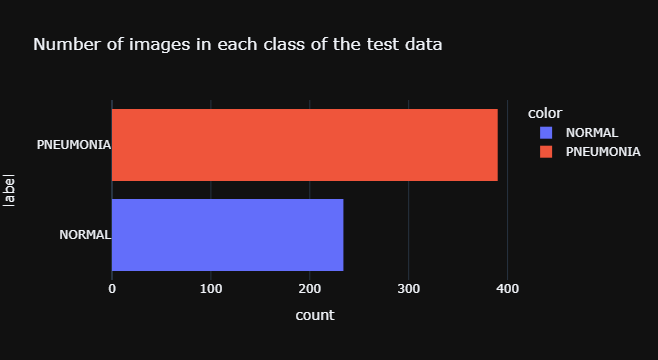

In [8]:
fig = px.histogram(data_frame=test,
                   y=test['label'],
                   template='plotly_dark',
                   color=test['label'].values,
                   title='Number of images in each class of the test data')
fig.show()


In [9]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=42)

Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


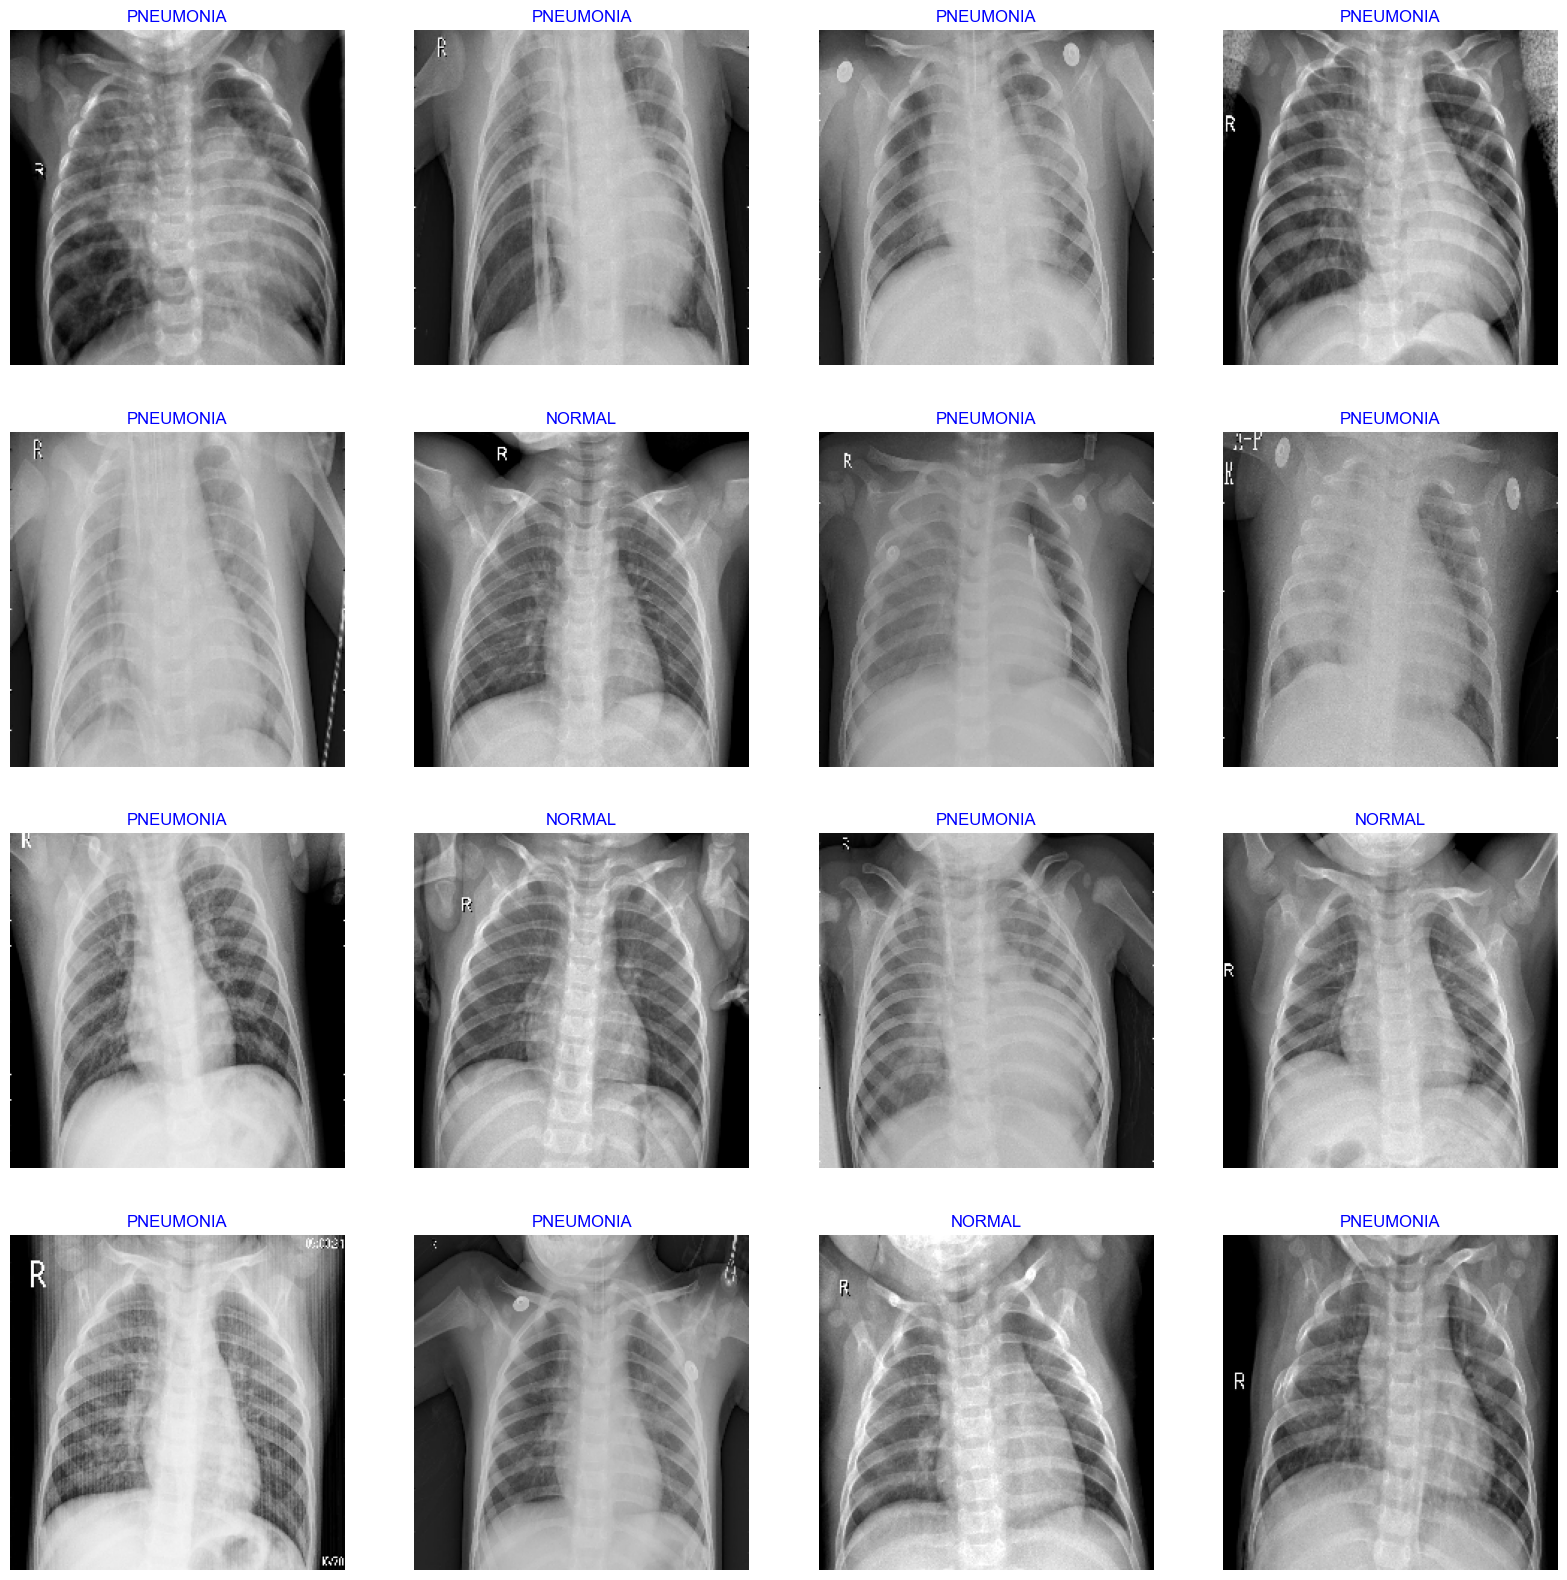

In [10]:
img_size = (224, 224)
batch_size = 16
img_shape = (img_size[0], img_size[1], 3)

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show();

In [11]:
img_size = (224, 224)
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])
model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
Epochs = 10
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen, validation_steps=None,
                    shuffle=False)

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 876s 3s/step - accuracy: 0.7036 - loss: 10.3658 - val_accuracy: 0.3019 - val_loss: 10.4756
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 814s 3s/step - accuracy: 0.8774 - loss: 6.1991 - val_accuracy: 0.8275 - val_loss: 5.8453
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 766s 3s/step - accuracy: 0.9066 - loss: 5.4053 - val_accuracy: 0.8882 - val_loss: 5.2810
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 1204s 5s/step - accuracy: 0.8500 - loss: 4.8583 - val_accuracy: 0.7955 - val_loss: 4.8384
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 782s 3s/step - accuracy: 0.8251 - loss: 4.3160 - val_accuracy: 0.9058 - val_loss: 4.6206
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.8201 - loss: 3.7430 - val_accuracy: 0.7332 - val_loss: 3.7096
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 768s 3s/step - accuracy: 0.7928 - loss: 3.1575 - val_accuracy: 0.7300 - val_loss: 3.0327
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 814s 3s/step - accuracy: 0.8161 - loss: 2.5830 - val_a

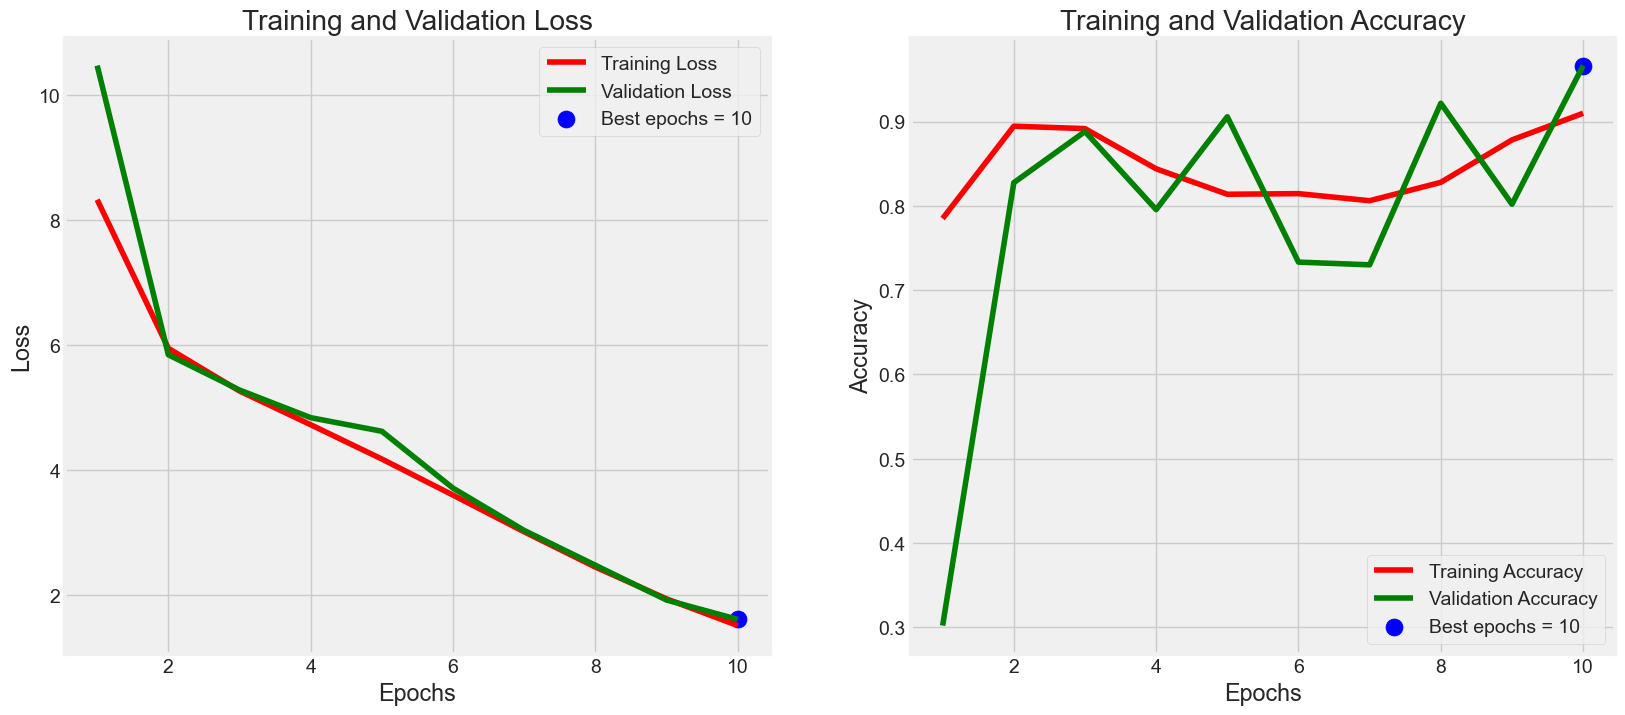

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 814ms/step - accuracy: 0.9710 - loss: 1.4004
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 913ms/step - accuracy: 0.9731 - loss: 1.4406
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9487 - loss: 1.3995
Train Loss:  1.3950327634811401
Train Accuracy:  0.95703125
--------------------
Validation Loss:  1.5580284595489502
Validation Accuracy:  0.96875
--------------------
Test Loss:  1.4020066261291504
Test Accuracy:  0.953125


In [13]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss + 1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

# Training history

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 776ms/step


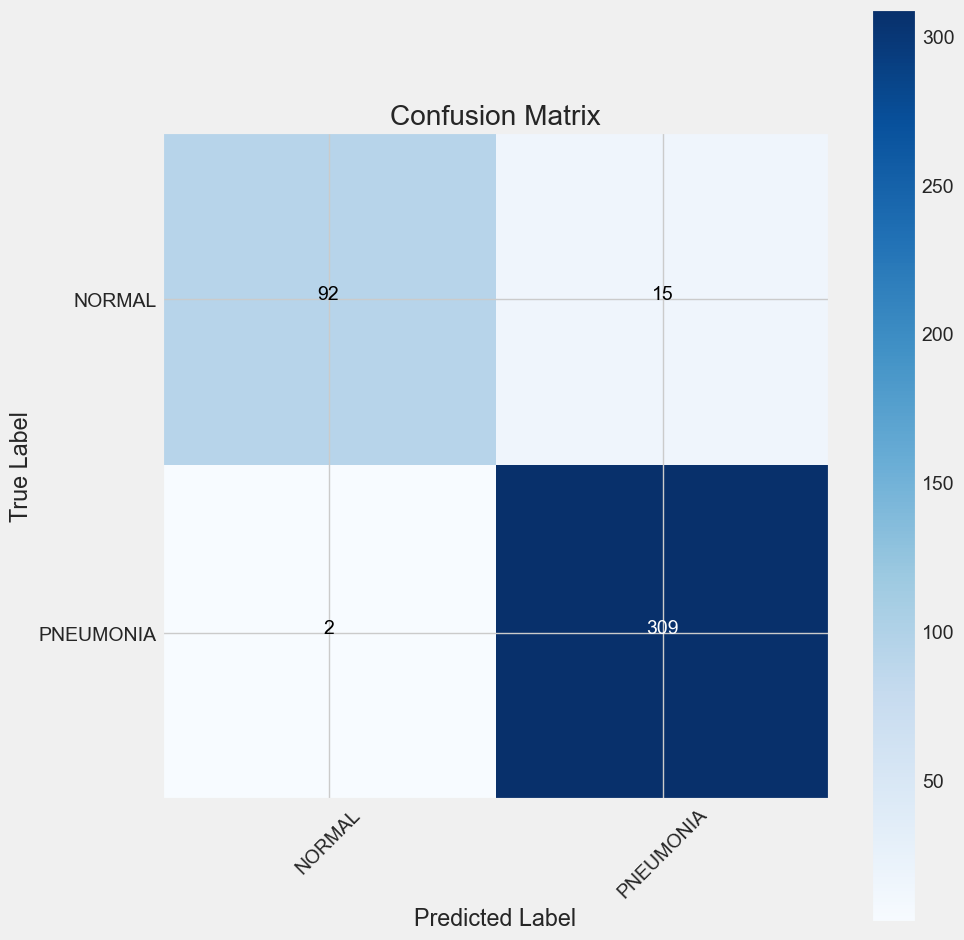

In [14]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.98      0.86      0.92       107
   PNEUMONIA       0.95      0.99      0.97       311

    accuracy                           0.96       418
   macro avg       0.97      0.93      0.94       418
weighted avg       0.96      0.96      0.96       418



In [16]:
recall = recall_score(test_gen.classes, y_pred, average='weighted')
f1 = f1_score(test_gen.classes, y_pred, average='weighted')

print("Recall:", recall)
print("F1 Score:", f1)

Recall: 0.9593301435406698
F1 Score: 0.9584312547948574
